# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер. За дополнительные эксперименты с методами и их анализ можно получить бонусные баллы.

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
plt.style.use('~/.config/matplotlib/stylelib/dracula.mplstyle')

In [3]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [4]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балла).** Реализуйте метрику $MAP@k$.

In [5]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    r = lambda u, i: predicted[u - 1][i - 1] in relevant[u - 1]   
    p = lambda u, k: 1 / k * sum([r(u, i) for i in range(1, 1 + k)])
    ap = lambda u, k: 1 / min(k, len(relevant[u - 1])) * sum([r(u, i) * p(u, i) for i in range(1, 1 + k)])
    
    return 1 / len(relevant) * sum([ap(u, k) for u in range(1, 1 + len(relevant))])  

In [6]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [7]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [8]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [9]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [10]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [11]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [12]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [13]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [14]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [15]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        
        test_preds = [self.recommend(id) for id in range(self.n_users)]
        test_preds = self.remove_train_items(test_preds, k)

        return test_preds[test_users]

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах 
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (0.5 балла).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [16]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    return (ratings @ user_vector) / (ratings.sum(axis=1)**0.5 * user_vector.sum()**0.5)


def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    return (ratings @ user_vector) / ((ratings + user_vector) > 0).sum(axis=1)

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [17]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        s = self.similarity(self.R[uid])        
        N = np.setdiff1d(np.argwhere(s > 0.02)[:, 0], [0], assume_unique=True)
        pred_r = (s[N] @ self.R[N]) / s[N].sum()
        return np.argsort(pred_r)[::-1]

In [65]:
model = User2User(train_ratings, similarity_func=pearson)
model.get_test_recommendations(15)

array([[ 9693,  7533,  6376, ...,  3106,  1666,   780],
       [24500,  2814, 33436, ..., 54220, 11950,  1019],
       [ 1073,  1019, 11493, ...,  3106,  7780,  6448],
       ...,
       [ 1019,   805,  9694, ..., 11493, 49577,  6773],
       [  805,  7533,  4032, ...,  5653,  6376,  3106],
       [18070, 33436,  2814, ..., 22325, 50211, 24290]])

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

In [19]:
pearson_model = User2User(train_ratings, similarity_func=pearson)
jaccard_model = User2User(train_ratings, similarity_func=jaccard)

In [20]:
pearosn_rec = pearson_model.get_test_recommendations(50)
jaccard_rec = jaccard_model.get_test_recommendations(50)
random_rec = np.asarray([tracks_info.sample(50)['id'] for _ in range(model.n_users)])

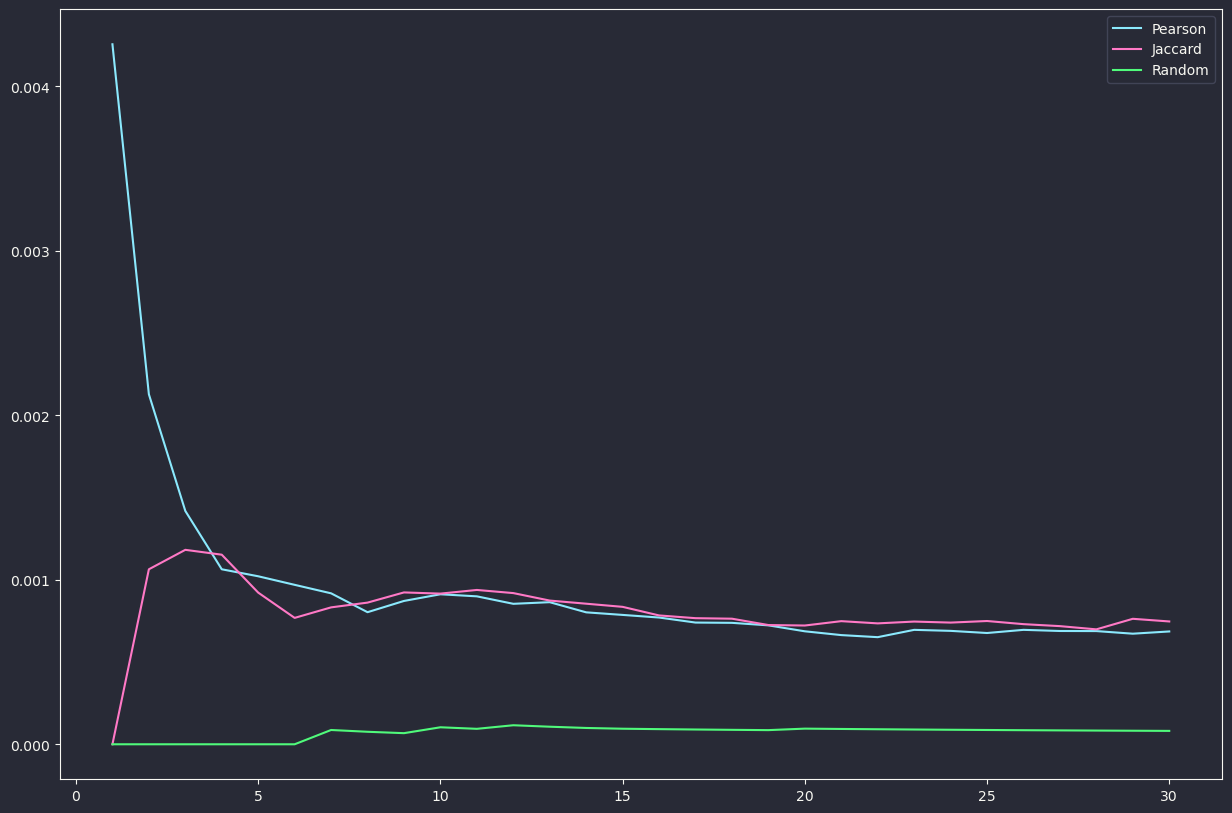

In [21]:
plt.figure(figsize=(15, 10))

k_values = range(1, 31)
mapk_pearson = [mapk(test_relevant, pearosn_rec, k) for k in k_values]
mapk_jaccard = [mapk(test_relevant, jaccard_rec, k) for k in k_values]
mapk_random = [mapk(test_relevant, random_rec, k) for k in k_values]

plt.plot(k_values, mapk_pearson, label='Pearson')
plt.plot(k_values, mapk_jaccard, label='Jaccard')
plt.plot(k_values, mapk_random, label='Random')
plt.legend()
plt.show()

> По какой-то непонятной причине при использовании меры Жаккара первый трек не попадает в релевантные и метрека зануляется, в то время как у Пирсона все хорошо. В остальном же алгоритм на обоих метриках работает практически одинаково.

**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [22]:
def pearson_sparse(ratings: scs.csr_matrix, user_vector: scs.csr_matrix) -> np.array:
    return np.asarray((ratings @ user_vector.T) / (np.asarray(ratings.sum(axis=1))**0.5 * user_vector.sum()**0.5))[:, 0]


def jaccard_sparse(ratings: scs.csr_matrix, user_vector: scs.csr_matrix) -> np.array:
    return (ratings @ user_vector.T).toarray()[:, 0] / ((ratings.toarray() + user_vector.toarray()[0]) > 0).sum(axis=1)

In [23]:
class User2UserSparse(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson_sparse, jaccard_sparse]

        self.similarity_func = similarity_func
        self.alpha = 0.02
        
        self.R = scs.csr_matrix(self.R)

    def similarity(self, user_vector: scs.csr_matrix):
        """
        user_vector: [n_items]
        """
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        s = self.similarity(self.R[uid])      
        N = np.setdiff1d(np.argwhere(s > 0.02)[:, 0], [0], assume_unique=True)
        pred_r = (s[N].T @ self.R[N]) / s[N].sum()
        return np.argsort(pred_r)[::-1]

In [24]:
sparse_model = User2UserSparse(train_ratings, similarity_func=pearson_sparse)
sparse_model.get_test_recommendations(15)

array([[ 9693,  7533,  6376, ...,  3106,  1666,   780],
       [24500,  2814, 33436, ..., 54220, 11950,  1019],
       [ 1073,  1019, 11493, ...,  3106,  7780,  6448],
       ...,
       [ 1019,   805,  9694, ..., 11493, 49577,  6773],
       [  805,  7533,  4032, ...,  5653,  6376,  3106],
       [18070, 33436,  2814, ..., 22325, 50211, 24290]])

In [25]:
import time
times = pd.DataFrame({'np.array': [0, 0], 'scs.csr_matrix': [0, 0]}, index=['Pearson', 'Jaccard'])

In [26]:
for f in [pearson, jaccard]:
    st = time.time()
    _ = User2User(train_ratings, similarity_func=f).get_test_recommendations(15)
    en = time.time()
    times.at['Pearson' if f.__name__.__contains__('pearson') else 'Jaccard', 'np.array'] = en - st

In [27]:
for f in [pearson_sparse, jaccard_sparse]:
    st = time.time()
    _ = User2UserSparse(train_ratings, similarity_func=f).get_test_recommendations(15)
    en = time.time()
    times.at['Pearson' if f.__name__.__contains__('pearson') else 'Jaccard', 'scs.csr_matrix'] = en - st

In [28]:
times['improvement'] = times['scs.csr_matrix'] / times['np.array']

In [29]:
times

,np.array,scs.csr_matrix,improvement
Pearson,4.923065,1.643552,0.333847
Jaccard,13.564447,11.480779,0.846388


> Для Пирсона мы получили очень значительные прирост, сократив время работа практически в 3 раза. С мерой Жаккару, к сожалению, удалось ускорить работу только на 15% - из-за самой природы метрики и ограничение scipy.sparse ускоряется только скалярное произведение.

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [69]:
user_id = np.random.randint(0, model.n_users)

In [70]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
60,Gives You Hell,['The All-American Rejects']
220,I Was Made For Lovin' You,['Kiss']
285,(I Can't Get No) Satisfaction,['The Rolling Stones']
288,Pump It,['Black Eyed Peas']
417,Just Lose It,['Eminem']
418,Without Me,['Eminem']
419,The Real Slim Shady,['Eminem']
465,Use Your Fist And Not Your Mouth,['Marilyn Manson']
504,Smack That,"['Akon', 'Eminem']"
508,Ass Like That,['Eminem']


In [71]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
59484,Юность,['Dabro']
62418,Снова я напиваюсь,['SLAVA MARLOW']
24500,Way Down We Go,['KALEO']
64683,I WANNA BE YOUR SLAVE,['Måneskin']
60665,Minor,['Miyagi & Andy Panda']
64005,Горький вкус,['Султан Лагучев']
54280,Комета,['JONY']
37861,Я так соскучился,['Порнофильмы']
59741,Поболело и прошло,['HENSY']
39265,Beggin',['Måneskin']


In [72]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
57541,ТРУБКИ,"['104', 'Скриптонит', 'SALUKI']"
57548,Не киряй,"['МУККА', 'Три дня дождя']"
57724,Выключили свет,['zavet']
57771,ПАРИЖ,['КУОК']
57802,Малолетка,['Макс Корж']
57932,Savage,['Megan Thee Stallion']
57994,ЭКИПАЖ,"['OFFMi', 'Хаски', 'bollywoodFM']"
58020,Psycho!,['MASN']
58280,12345SEX,['UPSAHL']
58327,WTF U MEAN,"['Haarper', 'Freddie Dredd']"


> Не берусь называть себя экспертом, но выглядят рекомендации так себе. Некоторые из исполнителей/жанров близки, но в целом хорошими рекомендациями это назвать нельзя. Особенно если сравнивать с уже прослушанными треками.

### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**LFM:**

$$p_{uk} = p_{uk} - \eta (\lambda p_{uk} - q_{ik}(r_{ui} - \langle p_{u},q_{i} \rangle))$$

$$q_{ik} = q_{ik} - \eta (\lambda q_{ik} - p_{uk}(r_{ui} - \langle p_{u},q_{i} \rangle))$$

> Source: [trust me bro](https://etd.ohiolink.edu/apexprod/rws_etd/send_file/send?accession=osu1491255524283942&disposition=inline),
[trust me bro 2: electric boogaloo](https://youtu.be/Olk1aR8dVho?t=378)

**ALS:** 

$$p_{u} = \left(\sum_{i: \exists r_{ui}} q_i q_i^T \right)^{-1} \sum_{i: \exists r_{ui}}r_{ui} q_i$$

$$q_{i} = \left(\sum_{u: \exists r_{ui}} p_u p_u^T \right)^{-1} \sum_{u: \exists r_{ui}}r_{ui} p_u$$

> Source: [trust me bro 3: the prequel](https://github.com/esokolov/ml-course-hse/blob/master/2020-spring/lecture-notes/lecture23-recommender.pdf)

**Задание 8 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [73]:
import itertools as it


class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode="sgd", lr=0.003, lamb=0.01):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ["sgd", "als"]
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = lr
        self.lamb = lamb

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):
            
            if self.mode == "sgd":
                for _ in range(10_000_000):
                    pix = np.random.randint(self.n_users)
                    qix = np.random.randint(self.n_items)
                    
                    if self.R[pix][qix] == 1:
                        e = self.R[pix][qix] - self.P[pix] @ self.Q[qix]
                        p = self.P[pix]

                        self.P[pix] -= self.lr * (self.lamb * self.P[pix] - self.Q[qix] * e)
                        self.Q[qix] -= self.lr * (self.lamb * self.Q[qix] - p * e)

            elif self.mode == "als":
                ### Source: http://ethen8181.github.io/machine-learning/recsys/1_ALSWR.html
                
                A = (self.Q.T @ self.Q) + np.eye(self.dim)
                b = self.R @ self.Q
                self.P = b @ np.linalg.inv(A)
                
                A = (self.P.T @ self.P) + np.eye(self.dim)
                b = self.R.T @ self.P
                self.Q = b @ np.linalg.inv(A)


            loss = ((self.R - self.P @ self.Q.T) ** 2).sum(axis=None) + self.lamb * (
                (self.P**2).sum(axis=None) + (self.Q**2).sum(axis=None)
            )
            acc = mapk(test_relevant, self.get_test_recommendations(15), 15)
            print(f"Loss: {loss}, MAP@15: {acc}")

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [49]:
sgd_model = HiddenVars(train_ratings)
sgd_model.fit(15)

  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 908364377.3412213, MAPK: 9.45626477541371e-05
Loss: 626461232.106968, MAPK: 0.0
Loss: 499296504.4156913, MAPK: 4.8355899419729206e-05
Loss: 430185719.3923807, MAPK: 0.0
Loss: 386100896.0400264, MAPK: 0.0
Loss: 356765434.4520481, MAPK: 0.0
Loss: 335289967.2031817, MAPK: 0.0
Loss: 319343061.9443912, MAPK: 0.0
Loss: 306513749.0355056, MAPK: 0.0
Loss: 296539755.867436, MAPK: 8.510638297872342e-05
Loss: 288225669.72503614, MAPK: 0.0
Loss: 281474955.1083375, MAPK: 0.00021276595744680854
Loss: 275450007.8166302, MAPK: 0.0
Loss: 270517290.82015526, MAPK: 0.0
Loss: 266091449.5693198, MAPK: 0.0


In [48]:
als_model = HiddenVars(train_ratings, mode='als')
als_model.fit(15)

  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 129393.26343254495, MAPK: 0.0016313442270889076
Loss: 32770.863435019906, MAPK: 0.0017936507936507937
Loss: 22120.82370810019, MAPK: 0.001614527316654976
Loss: 20834.05708509295, MAPK: 0.0011600220110858411
Loss: 20288.21451035496, MAPK: 0.0010472222812648343
Loss: 20011.524861344657, MAPK: 0.0012081535485790806
Loss: 19854.330560212507, MAPK: 0.001164143972654611
Loss: 19756.974700333532, MAPK: 0.0012253947785862678
Loss: 19692.41414413601, MAPK: 0.0012792660452234917
Loss: 19647.26416345611, MAPK: 0.0012403120913759209
Loss: 19614.381000952686, MAPK: 0.0011920451494919577
Loss: 19589.6786445701, MAPK: 0.0012435192860724776
Loss: 19570.669606892723, MAPK: 0.001088278939342769
Loss: 19555.755688513353, MAPK: 0.0010312988823627123
Loss: 19543.863325256243, MAPK: 0.0010130791194620983


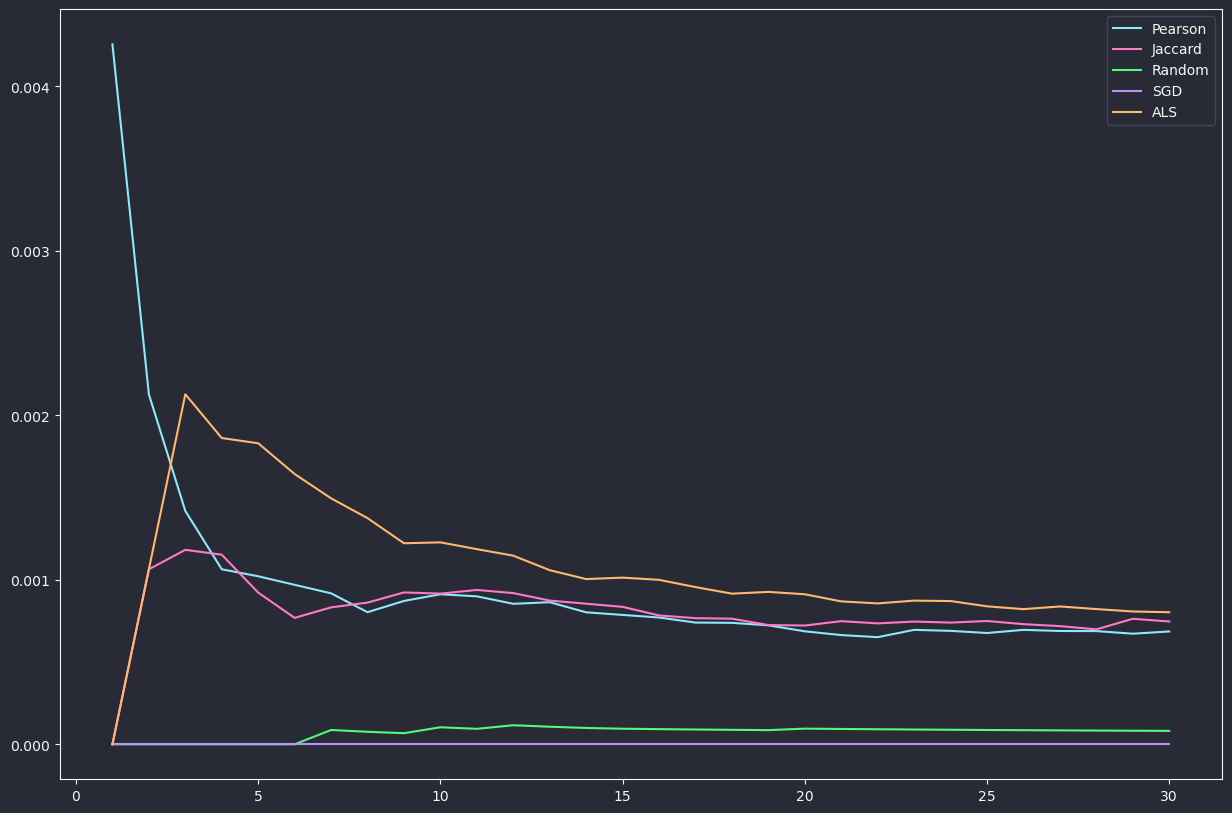

In [50]:
plt.figure(figsize=(15, 10))

sgd_rec = sgd_model.get_test_recommendations(50)
mapk_sgd = [mapk(test_relevant, sgd_rec, k) for k in k_values]

als_rec = als_model.get_test_recommendations(50)
mapk_als = [mapk(test_relevant, als_rec, k) for k in k_values]

plt.plot(k_values, mapk_pearson, label='Pearson')
plt.plot(k_values, mapk_jaccard, label='Jaccard')
plt.plot(k_values, mapk_random, label='Random')
plt.plot(k_values, mapk_sgd, label='SGD')
plt.plot(k_values, mapk_als, label='ALS')
plt.legend()
plt.show()

> Времени на подбор параметров к сожалению не хватило, но уже с базовой версией ALS заметен большой прорыв. С увеличением `k` он все же сходится к остальным алгоритмам, но для `k=3` разница почти в 2 раза.

> С алгоритмом SGD, однако, определнно что-то не так, так как он почти не обучается и даже дает результаты хуже случайного.

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [61]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

model = als_model
preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [62]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2058,Последний герой,['КИНО'],0.541444
2179,Восьмиклассница,['КИНО'],0.519758
5230,Call Me When You're Sober,['Evanescence'],0.470006
2060,Хочу перемен,['КИНО'],0.456554
5515,Романс,['Сплин'],0.452566
5513,Орбит без сахара,['Сплин'],0.452267
18908,Painkiller,['Three Days Grace'],0.432068
18592,Лондон,"['Григорий Лепс', 'Тимати']",0.430499
26075,Лошадка,['Найк Борзов'],0.423047
